In [19]:
from memo import memo
import jax.numpy as jnp
import jax
import numpy as np
from jax.scipy.special import logsumexp
from typing import Union
from tqdm import tqdm
from scipy.special import gammaln, logsumexp, softmax
from enum import IntEnum
from memo.lib import * 
import matplotlib.pyplot as plt
from scipy.stats import poisson

from world_jax import WorldJAX

from rsa_memo import *
from test_utils import *

### 1. Basic Building Blocks

##### world setup

In [20]:
#for task d: n=5, m=7
#for task a-c: n=1, m=7
worldJAX = WorldJAX(
    n=1,  # N independent binomial experiment
    m=7,  # each experiment has M Bernoulli trials
    theta_values=jnp.linspace(0, 1, 11)  # theta from 0 to 1
)
Theta = jnp.arange(len(worldJAX.theta_values))
U = jnp.arange(len(worldJAX.utterances))
Obs = jnp.arange(len(worldJAX.observations))
utterance_log_prob_obs = literal_semantics_uniform( jnp.array(worldJAX.utterance_truth.values))
obs_log_likelihood_theta = jnp.array(worldJAX.obs_log_likelihood_theta.values)
utterance_truth_matrix = jnp.array(worldJAX.utterance_truth.values)

#--------------- Set the Word Types for Memo ----------------#
Psi_dist = jnp.array([1/3, 1/3, 1/3])  # possible Psi values
Psi = jnp.arange(len(Psi_dist)) 
uniform_prior = jnp.ones(len(Theta)) / len(Theta)
alpha_values = jnp.array([1.0, 5.0, 10.0])  # Actual alpha values
Alpha = jnp.arange(len(alpha_values))  # Indices: 0, 1, 2

def is_utt_true_for_obs(u, obs):
    return utterance_truth_matrix[u, obs] > 0
def get_obs_prob(obs, theta):
    return jnp.exp(obs_log_likelihood_theta[obs, theta])
def get_utt_prob(u, obs):
    return jnp.exp(utterance_log_prob_obs[u, obs])
def marginalize_L1_vig(L1_vig_memo):
    p_theta_given_u = jnp.sum(L1_vig_memo, axis=(-1, -2))
    return p_theta_given_u

##### Low Levels

In [29]:
# Level 0
#。*
@memo
def S0[_obs: Obs, _u: U]():
    speaker: knows(_obs)
    speaker: chooses(u in U, wpp=is_utt_true_for_obs(u, _obs))
    return Pr[speaker.u == _u]

#。*
# this prior here means the listener's belief over theta distribution
@memo
def L0[_u: U, _theta: Theta](prior: ...):
    listener: knows(_u, _theta)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    return listener[Pr[world.theta == _theta]] 

# Level 1
#seems not used... maybe still keep it for now
@memo
def S0_belief[_obs: Obs, _u: U, _theta: Theta](prior: ...):
    speaker: knows(_obs, _theta, _u)
    speaker: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta))
    ]
    speaker: observes [world.obs] is _obs
    speaker: chooses(u in U, wpp=is_utt_true_for_obs(u, _obs)) 
    return E[speaker[Pr[world.theta == _theta]]]
    return Pr[speaker.u == _u]

#used for S1 inf. the prior here means the listener's belief over theta distribution
@memo
def L0_obs[_u: U, _obs: Obs](prior: ...):
    listener: knows(_u, _obs)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    return listener[Pr[world.obs == _obs]]

#。*
# this 'prior' here means the imagined listener's belief over theta distribution
@memo
def S1_inf[_obs: Obs, _u: U](prior: ..., alpha):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U, 
        wpp=is_utt_true_for_obs(u, _obs) * exp(alpha * log(L0_obs[u, _obs](prior) + 1e-10))
    )
    return Pr[speaker.u == _u]

#used for S1 pers. the 'prior' here means the imagined listener's belief over theta distribution
    #we need to include theta_values here to compute expected theta, here just pass worldJAX.theta_values
@memo
def L0_expected_theta[_u: U](prior: ..., theta_values: ...):
    listener: knows(_u)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: chooses(u in U, wpp=get_utt_prob(u, obs))
    ]
    listener: observes [world.u] is _u
    return listener[E[array_index(theta_values, world.theta)]]


# this 'prior' here means the imagined listener's belief over theta distribution
@memo
def S1_pers_up[_obs: Obs, _u: U](prior: ..., alpha, theta_values: ...):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U,
        wpp=is_utt_true_for_obs(u, _obs) * exp(
            alpha * log(L0_expected_theta[u](prior, theta_values) + 1e-10)
        )
    )
    return Pr[speaker.u == _u]

# this 'prior' here means the imagined listener's belief over theta distribution
@memo  
def S1_pers_down[_obs: Obs, _u: U](prior: ..., alpha, theta_values: ...):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U,
        wpp=is_utt_true_for_obs(u, _obs) * exp(
            alpha * log(1.0 - L0_expected_theta[u](prior, theta_values) + 1e-10)
        ) 
    )
    return Pr[speaker.u == _u]

#。*
#this function combines pers_up, pers_down, inf into one function with psi parameter
#this prior here means the imagined listener's belief over theta distribution
@memo  
def S1_pers[_obs: Obs, _u: U](prior: ..., alpha, theta_values: ..., psi):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U,
        wpp=(
            # psi == 2.0: pers_down
            is_utt_true_for_obs(u, _obs) * exp(alpha * log(1.0 - L0_expected_theta[u](prior, theta_values) + 1e-10))
            if psi == 2.0
            else (
                # psi == 1.0: pers_up
                is_utt_true_for_obs(u, _obs) * exp(alpha * log(L0_expected_theta[u](prior, theta_values) + 1e-10))
                if psi == 1.0
                # psi == 0.0: inf
                else is_utt_true_for_obs(u, _obs) * exp(alpha * log(L0_obs[u, _obs](prior) + 1e-10))
            )
        )
    )
    return Pr[speaker.u == _u]

#。*
#prior here means this listener's belief over theta distribution & imagined L0 within S1's prior 
#!!ASSUMPTION: this listener believes that when speaker imaging L0, it's also knowing L1's prior?
@memo
def L1_cred[_u: U, _theta: Theta, _alpha: Alpha](prior: ..., l0_prior: ..., alpha_dist: ..., alpha_vals: ...):
    """
    L1 listener who infers theta from utterance u,
    assuming speaker is S1_inf (informed speaker)
    """
    listener: knows(_u, _theta, _alpha)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        speaker: knows(world.obs),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(array_index(alpha_vals, alp) * log(L0_obs[u, world.obs](l0_prior) + 1e-10))
        )
    ]
    listener: observes[speaker.u] is _u
    return listener[Pr[world.theta == _theta, speaker.alp == _alpha]]

#。*
#prior here means this listener's belief over theta distribution & imagined L0 within S1's prior 
#!!ASSUMPTION: this listener believes that when speaker imaging L0, it's also knowing L1's prior?
@memo
def L1_vig[_u: U, _theta: Theta, _alpha: Alpha, _psi: Psi](prior: ..., l0_prior: ..., alpha_dist:..., alpha_values:..., psi_dist: ..., theta_values: ...):
    listener: knows(_u, _theta, _alpha, _psi)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: given(stype in Psi, wpp=array_index(psi_dist, stype)),
        speaker: knows(world.obs, world.stype),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(
                array_index(alpha_values, alp) * log(
                    (world.stype == 0) * L0_obs[u, world.obs](l0_prior) +
                    (world.stype == 1) * L0_expected_theta[u](l0_prior, theta_values) +
                    (world.stype == 2) * (1.0 - L0_expected_theta[u](l0_prior, theta_values))
                    + 1e-10
                )
            )
        )
    ]
    listener: observes [speaker.u] is _u
    return listener[Pr[world.theta == _theta, speaker.alp == _alpha, world.stype == _psi]]

# Level 2
#used for S2 inf.the prior here means BOTH THIS L1 & the imagined L0 within S1's prior
@memo
def L1_cred_obs[_u: U, _obs: Obs](prior: ..., l0_prior:..., alpha_dist: ..., alpha_vals: ...):
    listener: knows(_u, _obs)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        speaker: knows(world.obs),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(array_index(alpha_vals, alp) * log(L0_obs[u, world.obs](l0_prior) + 1e-10))
        )
    ]
    listener: observes[speaker.u] is _u
    return listener[Pr[world.obs == _obs]]

#。*
#prior here means the prior for the imagined L1 within S2's prior
@memo
def S2_inf[_obs: Obs, _u: U](prior: ..., l0_prior:..., alpha,alpha_dist:..., alpha_values:..., ):
    speaker: knows(_obs, _u)
    speaker: chooses(
        u in U, 
        wpp=is_utt_true_for_obs(u, _obs) * exp(alpha * log(L1_cred_obs[u, _obs](prior, l0_prior, alpha_dist, alpha_values) + 1e-10))
    )
    return Pr[speaker.u == _u]

#used for S2 pers. 
    #the prior here means BOTH THIS L1 & the imagined L0 within S1's prior
@memo
def L1_vig_obs[_u: U, _obs: Obs, _alpha: Alpha, _psi: Psi](prior: ..., l0_prior:..., alpha_dist:..., alpha_values:..., psi_dist: ..., theta_values: ...):
    listener: knows(_u, _obs, _alpha, _psi)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: given(stype in Psi, wpp=array_index(psi_dist, stype)),
        speaker: knows(world.obs, world.stype),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(
                array_index(alpha_values, alp) * log(
                    (world.stype == 0) * L0_obs[u, world.obs](l0_prior) +
                    (world.stype == 1) * L0_expected_theta[u](l0_prior, theta_values) +
                    (world.stype == 2) * (1.0 - L0_expected_theta[u](l0_prior, theta_values))
                    + 1e-10
                )
            )
        )
    ]
    listener: observes [speaker.u] is _u
    return listener[Pr[world.obs == _obs]]

#used for S2 pers. 
    #the prior here means BOTH THIS L1 & the imagined L0 within S1's prior
@memo
def L1_vig_expected_theta[_u: U, _theta: Theta, _alpha: Alpha, _psi: Psi](prior: ..., l0_prior:..., alpha_dist:..., alpha_values:..., psi_dist: ..., theta_values: ...):
    listener: knows(_u, _theta, _alpha, _psi)
    listener: thinks[
        world: chooses(theta in Theta, wpp=array_index(prior, theta)),
        world: chooses(obs in Obs, wpp=get_obs_prob(obs, theta)),
        world: given(stype in Psi, wpp=array_index(psi_dist, stype)),
        speaker: knows(world.obs, world.stype),
        speaker: chooses(alp in Alpha, wpp=array_index(alpha_dist, alp)),
        speaker: chooses(
            u in U,
            wpp=is_utt_true_for_obs(u, world.obs) * exp(
                array_index(alpha_values, alp) * log(
                    (world.stype == 0) * L0_obs[u, world.obs](l0_prior) +
                    (world.stype == 1) * L0_expected_theta[u](l0_prior, theta_values) +
                    (world.stype == 2) * (1.0 - L0_expected_theta[u](l0_prior, theta_values))
                    + 1e-10
                )
            )
        )
    ]
    listener: observes [speaker.u] is _u
    return listener[E[array_index(theta_values, world.theta)]]

#used for S2 pers. 
    #the prior here means BOTH THIS L1 & the imagined L0 within S1's prior
@memo  
def S2_pers[_obs: Obs, _u: U, _alpha: Alpha, _psi: Psi, _theta: Theta](prior: ..., l0_prior:..., alpha, alpha_dist:..., alpha_values:..., theta_values: ..., psi, psi_dist: ...):
    speaker: knows(_obs, _u, _alpha, _psi, _theta)
    speaker: chooses(
        u in U,
        wpp=(
            # psi == 2.0: pers_down - minimize L1_vig's expected theta
            is_utt_true_for_obs(u, _obs) * exp(
                alpha * log(1.0 - L1_vig_expected_theta[u,_theta, _alpha, _psi](prior, l0_prior, alpha_dist, alpha_values, psi_dist, theta_values) + 1e-10)
            )
            if psi == 2.0
            else (
                # psi == 1.0: pers_up - maximize L1_vig's expected theta
                is_utt_true_for_obs(u, _obs) * exp(
                    alpha * log(L1_vig_expected_theta[u, _theta, _alpha, _psi](prior, l0_prior, alpha_dist, alpha_values, psi_dist, theta_values) + 1e-10)
                )
                if psi == 1.0
                # psi == 0.0: inf - maximize informativeness about obs for L1_vig
                else is_utt_true_for_obs(u, _obs) * exp(
                    alpha * log(L1_vig_obs[u, _obs, _alpha, _psi](prior,l0_prior, alpha_dist, alpha_values, psi_dist, theta_values) + 1e-10)
                )
            )
        )
    )
    return Pr[speaker.u == _u]

### 2. Tests

##### ✅ a] validate L1_vig -- can you verify it reduces to L1_cred when psi_dist = [1, 0, 0]

In [22]:
Psi_dist = jnp.array([1, 0, 0])
L1_vig_memo = L1_vig(uniform_prior, uniform_prior, jnp.array([1.0]), alpha_values, Psi_dist, worldJAX.theta_values)
L1_vig_memo = L1_vig(uniform_prior, uniform_prior, jnp.array([1.0]), alpha_values, Psi_dist, worldJAX.theta_values)
L1_vig_clean = jnp.sum(L1_vig_memo, axis=(-1, -2))

L1_cred_memo = L1_cred(uniform_prior, uniform_prior, jnp.array([1.0]), alpha_values)
L1_cred_clean = jnp.sum(L1_cred_memo, axis=(-1))

compare_two_matrix(L1_vig_clean, L1_cred_clean)

Total num of entries: 88
Entry with differences: 0,  0.00%
Exactly the same!

BIGGEST DIFFERENCE at: observation 0, utterance 0
  The difference number: 0.000000e+00
  base version: 0.000000
  memo version: 0.000000



##### ✅ b] bimodal posterior for "some, effective" (reproduce figure 3 on L0 & L1s)

In [23]:
# Fine the index of some,some,successful
utterance_target = 'some,successful'
u_idx =worldJAX.utterances.index(utterance_target)

# Set parameters
uniform_prior = jnp.ones(len(Theta)) / len(Theta) 
alpha_values = jnp.array([3.0])  
alpha_dist = jnp.array([1.0])  
Psi_dist = jnp.array([1/3, 1/3, 1/3]) 

# Initialize the agents
    # L0
L0_memo = L0(uniform_prior)
L0_posterior = L0_memo[u_idx, :]
L0_posterior = L0_posterior / jnp.sum(L0_posterior)
    # L1_cred
L1_cred_dist = L1_cred(uniform_prior, uniform_prior, alpha_dist, alpha_values)  
L1_cred_posterior = jnp.sum(L1_cred_dist[u_idx, :, :], axis=-1)  
L1_cred_posterior = L1_cred_posterior / jnp.sum(L1_cred_posterior)
    # L1_vig
L1_vig_memo = L1_vig(uniform_prior, uniform_prior, alpha_dist, alpha_values, Psi_dist, worldJAX.theta_values)
L1_vig_posterior_theta = jnp.sum(L1_vig_memo[u_idx, :, :, :], axis=(-1, -2))
L1_vig_posterior_theta = L1_vig_posterior_theta / jnp.sum(L1_vig_posterior_theta)
        #get P(psi|u) by marginalizing over theta and alpha
L1_vig_posterior_psi = jnp.sum(L1_vig_memo[u_idx, :, :, :], axis=(0, 1))
L1_vig_posterior_psi = L1_vig_posterior_psi / jnp.sum(L1_vig_posterior_psi)
L1_vig_posterior_psi_reordered = L1_vig_posterior_psi[jnp.array([2, 0, 1])]

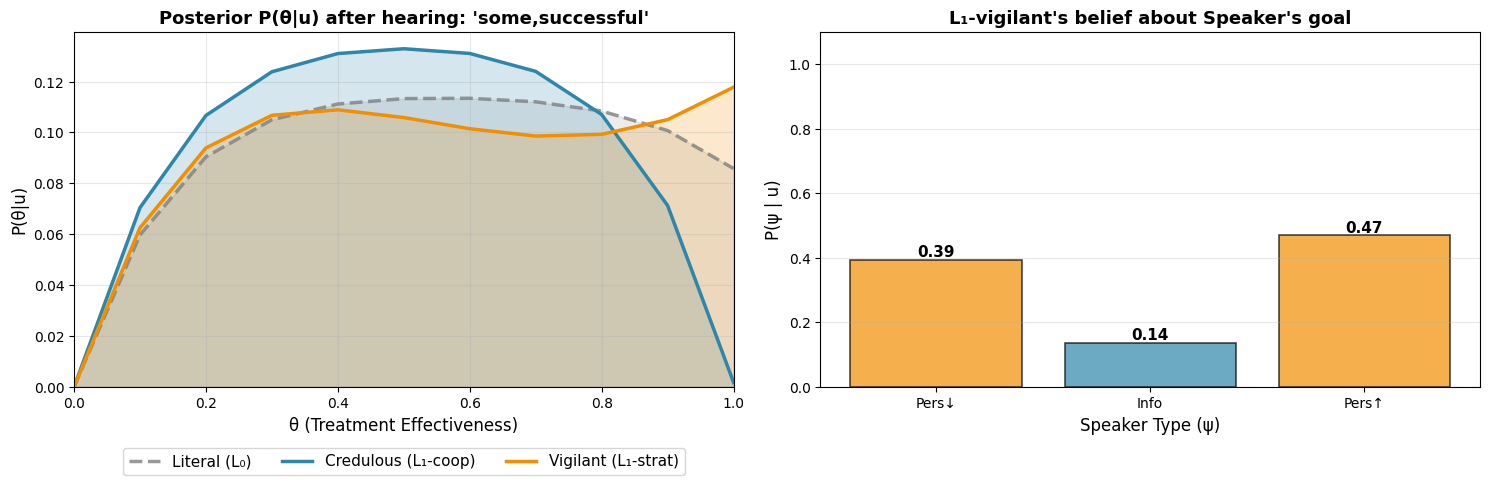

=== Posterior Beliefs after hearing 'some,successful' ===
Expected θ:
  L0 (Literal):           0.566
  L1_cred (Credulous):    0.501
  L1_vig (Vigilant):      0.575

L1_vig's belief about Speaker's goal:
  P(Speaker wants to persuade down) = 0.394
  P(Speaker is credible/informative) = 0.136
  P(Speaker wants to persuade up)    = 0.469


In [24]:
# Plotting & Analyzing
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
theta_vals = worldJAX.theta_values

# Plot 1: P(θ|u) for different listeners
ax = axes[0]
ax.plot(theta_vals, L0_posterior, '--', color='gray', linewidth=2.5, label='Literal (L₀)', alpha=0.8)
ax.plot(theta_vals, L1_cred_posterior, '-', color='#2E86AB', linewidth=2.5, label='Credulous (L₁-coop)')
ax.plot(theta_vals, L1_vig_posterior_theta, '-', color='#F18F01', linewidth=2.5, label='Vigilant (L₁-strat)')

# Fill areas under curves
ax.fill_between(theta_vals, 0, L0_posterior, alpha=0.15, color='gray')
ax.fill_between(theta_vals, 0, L1_cred_posterior, alpha=0.2, color='#2E86AB')
ax.fill_between(theta_vals, 0, L1_vig_posterior_theta, alpha=0.2, color='#F18F01')

ax.set_xlabel('θ (Treatment Effectiveness)', fontsize=12)
ax.set_ylabel('P(θ|u)', fontsize=12)
ax.set_title(f"Posterior P(θ|u) after hearing: '{utterance_target}'", fontsize=13, fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, None])

# Plot 2: P(psi|u) for L1_vig
ax = axes[1]
psi_labels = ['Pers↓', 'Info', 'Pers↑']
colors = ['#F18F01', '#2E86AB', '#F18F01']
bars = ax.bar(psi_labels, L1_vig_posterior_psi_reordered, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, L1_vig_posterior_psi_reordered)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('P(ψ | u)', fontsize=12)
ax.set_xlabel('Speaker Type (ψ)', fontsize=12)
ax.set_title(f"L₁-vigilant's belief about Speaker's goal", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])  # Extra space for labels

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"=== Posterior Beliefs after hearing '{utterance_target}' ===")
print(f"Expected θ:")
print(f"  L0 (Literal):           {jnp.sum(L0_posterior * theta_vals):.3f}")
print(f"  L1_cred (Credulous):    {jnp.sum(L1_cred_posterior * theta_vals):.3f}")
print(f"  L1_vig (Vigilant):      {jnp.sum(L1_vig_posterior_theta * theta_vals):.3f}")
print(f"\nL1_vig's belief about Speaker's goal:")
print(f"  P(Speaker wants to persuade down) = {L1_vig_posterior_psi_reordered[0]:.3f}")
print(f"  P(Speaker is credible/informative) = {L1_vig_posterior_psi_reordered[1]:.3f}")
print(f"  P(Speaker wants to persuade up)    = {L1_vig_posterior_psi_reordered[2]:.3f}")

#####  ✅ c] L1 & L2 speakers (reproduce figure 8)

In [25]:
worldJAX.observations

[(0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 1, 0, 0, 0),
 (0, 0, 0, 1, 0, 0, 0, 0),
 (0, 0, 1, 0, 0, 0, 0, 0),
 (0, 1, 0, 0, 0, 0, 0, 0),
 (1, 0, 0, 0, 0, 0, 0, 0)]

In [30]:
# Select observations: 0/7, 2/7, 4/7 effective
obs_0_7_idx = 7 
obs_2_7_idx = 5 
obs_4_7_idx = 3 
observations_to_plot = [
    (obs_0_7_idx, "0/7 effective"),
    (obs_2_7_idx, "2/7 effective"),
    (obs_4_7_idx, "4/7 effective")
]

S2_pers_down = S2_pers(uniform_prior, uniform_prior, alpha=3.0, alpha_dist=alpha_dist, alpha_values=alpha_values, theta_values=worldJAX.theta_values, psi=2.0, psi_dist=Psi_dist)
S2_pers_up = S2_pers(uniform_prior, uniform_prior, alpha=3.0, alpha_dist=alpha_dist, alpha_values=alpha_values, theta_values=worldJAX.theta_values, psi=1.0, psi_dist=Psi_dist)
S2_pers_inf = S2_pers(uniform_prior, uniform_prior,alpha=3.0, alpha_dist=alpha_dist, alpha_values=alpha_values, theta_values=worldJAX.theta_values, psi=0.0, psi_dist=Psi_dist)
S2_inf_coop = S2_inf(uniform_prior, uniform_prior, alpha=3.0, alpha_dist=alpha_dist, alpha_values=alpha_values)

S1_pers_down = S1_pers(uniform_prior, alpha=3.0, theta_values=worldJAX.theta_values, psi=2.0)
S1_pers_up = S1_pers(uniform_prior, alpha=3.0, theta_values=worldJAX.theta_values, psi=1.0)
S1_pers_inf = S1_pers(uniform_prior, alpha=3.0, theta_values=worldJAX.theta_values, psi=0.0)
S1_inf_coop = S1_inf(uniform_prior, alpha=3.0)

# Marginalize S2_pers if needed (handle extra dimensions)
if len(S2_pers_inf.shape) > 2:
    print(f"Marginalizing S2_pers from shape {S2_pers_inf.shape} to (obs, u)")
    S2_pers_inf = jnp.sum(S2_pers_inf, axis=tuple(range(2, len(S2_pers_inf.shape))))
    S2_pers_up = jnp.sum(S2_pers_up, axis=tuple(range(2, len(S2_pers_up.shape))))
    S2_pers_down = jnp.sum(S2_pers_down, axis=tuple(range(2, len(S2_pers_down.shape))))
print("✓ All distributions computed!")
print(f"  S1 shape: {S1_inf_coop.shape}")
print(f"  S2 shape: {S2_inf_coop.shape}")

Marginalizing S2_pers from shape (8, 8, 3, 3, 11) to (obs, u)
✓ All distributions computed!
  S1 shape: (8, 8)
  S2 shape: (8, 8)


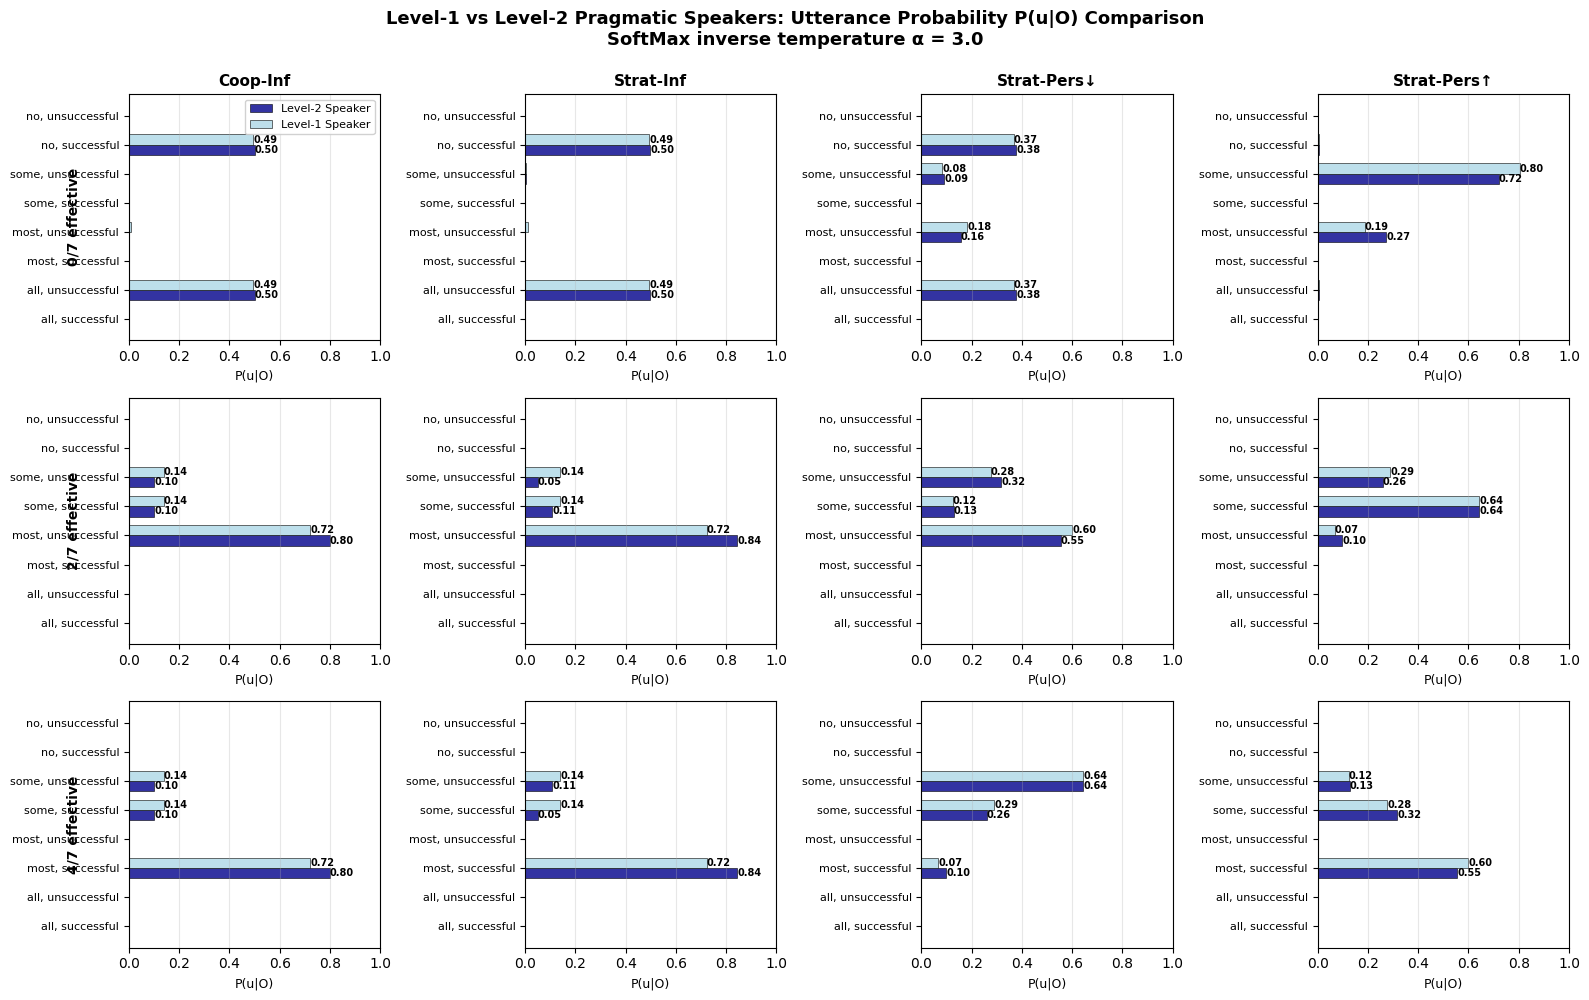

In [31]:
# Create visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Level-1 vs Level-2 Pragmatic Speakers: Utterance Probability P(u|O) Comparison\nSoftMax inverse temperature α = 3.0',
             fontsize=13, fontweight='bold', y=0.995)

speaker_configs = [
    ('Coop-Inf', S1_inf_coop, S2_inf_coop),
    ('Strat-Inf', S1_pers_inf, S2_pers_inf),
    ('Strat-Pers↓', S1_pers_down, S2_pers_down),
    ('Strat-Pers↑', S1_pers_up, S2_pers_up),
]

for row_idx, (obs_idx, obs_label) in enumerate(observations_to_plot):
    for col_idx, (speaker_name, s1_dist, s2_dist) in enumerate(speaker_configs):
        ax = axes[row_idx, col_idx]
        
        # Get probabilities
        s1_probs = np.array(s1_dist[obs_idx, :])
        s2_probs = np.array(s2_dist[obs_idx, :])
        
        # Normalize if needed
        if np.sum(s1_probs) > 0:
            s1_probs = s1_probs / np.sum(s1_probs)
        if np.sum(s2_probs) > 0:
            s2_probs = s2_probs / np.sum(s2_probs)
        
        # Create bar positions
        y_pos = np.arange(len(worldJAX.utterances))
        bar_height = 0.35
        
        # Plot bars
        ax.barh(y_pos - bar_height/2, s2_probs, bar_height,
                label='Level-2 Speaker', color='darkblue', alpha=0.8, edgecolor='black', linewidth=0.5)
        ax.barh(y_pos + bar_height/2, s1_probs, bar_height,
                label='Level-1 Speaker', color='lightblue', alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels for significant probabilities
        for i, (s1_p, s2_p) in enumerate(zip(s1_probs, s2_probs)):
            if s1_p > 0.05:
                ax.text(s1_p, i + bar_height/2, f'{s1_p:.2f}',
                       va='center', ha='left', fontsize=7, fontweight='bold')
            if s2_p > 0.05:
                ax.text(s2_p, i - bar_height/2, f'{s2_p:.2f}',
                       va='center', ha='left', fontsize=7, fontweight='bold')
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels([u.replace(',', ', ') for u in worldJAX.utterances], fontsize=8)
        ax.set_xlabel('P(u|O)', fontsize=9)
        ax.set_xlim([0, 1.0])
        ax.grid(True, alpha=0.3, axis='x')
        
        # Titles
        if row_idx == 0:
            ax.set_title(speaker_name, fontsize=11, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.22, 0.5, obs_label, transform=ax.transAxes,
                   fontsize=10, fontweight='bold', rotation=90,
                   va='center', ha='center')
        
        # Legend only on first subplot
        if row_idx == 0 and col_idx == 0:
            ax.legend(loc='upper right', fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.show()

##### d] simulation loop that runs 1000 simulations × 100 rounds

Figures 4-7 need a simulation loop that runs 1000 simulations × 100 rounds, tracks E[θ] and MAP estimates per round, and computes bias and std across runs (hopefully this will be a lot faster now so it'd be cool to timeit!)

4 pairings:
1. **Informative S₁ × Credulous L₁**
2. **Informative S₁ × Vigilant L₁**
3. **Persuasive-down S₁ × Credulous L₁**
4. **Persuasive-down S₁ × Vigilant L₁**

Each simulation: 1000 runs × 100 rounds

**NOTES: HAVE TO RE-RUN world setup bc NOW RUNNING ON DIFFERENT WORLD**

##### --helper function

In [32]:
import time
from typing import Callable, Dict, Tuple
import pandas as pd

def bayesian_update(prior, likelihood):
    """
    Bayesian update: P(theta|u) ∝ P(u|theta) * P(theta)
    """
    posterior = likelihood * prior
    posterior = posterior / jnp.sum(posterior)
    return posterior


def compute_expected_theta(posterior, theta_values):
    """Compute E[θ] given posterior distribution"""
    return jnp.sum(posterior * theta_values)


def compute_map_theta(posterior, theta_values):
    """Compute MAP estimate of θ"""
    map_idx = jnp.argmax(posterior)
    return theta_values[map_idx]


def compute_bias_and_std(results_df: pd.DataFrame, true_theta: float) -> pd.DataFrame:
    stats = []
    
    for round_idx in results_df['round'].unique():
        round_data = results_df[results_df['round'] == round_idx]
        
        # Expected theta statistics
        expected_vals = round_data['expected_theta'].values
        mean_expected = np.mean(expected_vals)
        bias_expected = mean_expected - true_theta
        std_expected = np.std(expected_vals)
        
        # MAP theta statistics
        map_vals = round_data['map_theta'].values
        mean_map = np.mean(map_vals)
        bias_map = mean_map - true_theta
        std_map = np.std(map_vals)
        
        stats.append({
            'round': round_idx,
            'mean_expected': mean_expected,
            'bias_expected': bias_expected,
            'std_expected': std_expected,
            'mean_map': mean_map,
            'bias_map': bias_map,
            'std_map': std_map
        })
    
    return pd.DataFrame(stats)

##### --simulation function

In [34]:
# MAIN SIMULATION FUNCTION
# Change it to set up the interaction rules 
def run_single_dyad_simulation(
    true_theta: float,
    speaker_psi: float,  # 0.0=inf, 2.0=pers_down
    listener_type: str,  # 'cred' or 'vig'
    world: WorldJAX,
    n_rounds: int,
    run_seed: int,
    alpha: float = 3.0,
    alpha_dist = None,
    alpha_values = None,
    psi_dist = None
) -> Dict:
    # Initialize
    theta_values = world.theta_values
    uniform_prior = jnp.ones(len(theta_values)) / len(theta_values)
    
    # Storage
    expected_thetas = []
    map_thetas = []
    posteriors = []
    observations_list = []  
    utterances_list = [] 
    psi_posteriors = []
    alpha_posteriors = []
    # Current listener belief (updated each round)
    listener_prior = uniform_prior
    listener_psi_belief = psi_dist.copy() if psi_dist is not None else None
    listener_alpha_belief = alpha_dist.copy() if alpha_dist is not None else None
        #we try to update the imagined L0 also
    l0_prior = uniform_prior.copy()

    # Sample observations for this run
    observations_df = world.sample_run(theta=true_theta, n_round=n_rounds, run_seed=run_seed)
    observations = observations_df['observation'].values
    
    for round_idx in range(n_rounds):
        # 1. World generates observation
        obs = observations[round_idx]
        obs_idx = world.observations.index(obs)
        observations_list.append(obs)
        # 2. Speaker produces utterance
        speaker_dist = S1_pers(l0_prior, alpha, theta_values, speaker_psi)[obs_idx, :]
        
        # 3. Sample utterance from speaker distribution
        rng = np.random.default_rng(run_seed + round_idx * 10000)
        u_idx = rng.choice(len(speaker_dist), p=np.array(speaker_dist))
        utterances_list.append(world.utterances[u_idx])
        # 4. Listener updates belief based on utterance
        if listener_type == 'cred':
            listener_full_dist = L1_cred(listener_prior, l0_prior, listener_alpha_belief, alpha_values)[u_idx, :, :]
            posterior = jnp.sum(listener_full_dist, axis=1)  # Marginalize over alpha
            alpha_posterior = jnp.sum(listener_full_dist, axis=0)  # sum over theta
            alpha_posterior = alpha_posterior / jnp.sum(alpha_posterior)
            alpha_posteriors.append(alpha_posterior)
            psi_posteriors.append(None)
            listener_alpha_belief = alpha_posterior
        elif listener_type == 'vig':
            listener_full_dist = L1_vig(listener_prior, l0_prior, listener_alpha_belief, alpha_values, listener_psi_belief, theta_values)[u_idx, :, :, :]
            posterior = jnp.sum(listener_full_dist, axis=(1, 2))  
            psi_posterior = jnp.sum(listener_full_dist, axis=(0, 1))
            alpha_posterior = jnp.sum(listener_full_dist, axis=(0, 2))  
            psi_posterior = psi_posterior / jnp.sum(psi_posterior)
            alpha_posterior = alpha_posterior / jnp.sum(alpha_posterior)
            psi_posteriors.append(psi_posterior)
            alpha_posteriors.append(alpha_posterior)
            listener_psi_belief = psi_posterior
            listener_alpha_belief = alpha_posterior
        else:
            raise ValueError(f"Unknown listener type: {listener_type}")
        
        posterior = posterior / jnp.sum(posterior)
        #FOR TESTING IF WE UPDATE THE IMAGINED L0 ALSO
        l0_updated = L0(l0_prior)[u_idx, :]
        l0_prior = l0_updated / jnp.sum(l0_updated)
        
        # 5. Compute statistics
        expected_theta = compute_expected_theta(posterior, theta_values)
        map_theta = compute_map_theta(posterior, theta_values)
        
        # 6. Store results
        expected_thetas.append(float(expected_theta))
        map_thetas.append(float(map_theta))
        posteriors.append(posterior)
        
        # 7. Update prior for next round (Bayesian learning)
        listener_prior = posterior
    
    return {
        'expected_theta': expected_thetas,
        'map_theta': map_thetas,
        'posteriors': posteriors,
        'psi_posteriors': psi_posteriors,
        'alpha_posteriors': alpha_posteriors,
        'observations': observations_list,  
        'utterances': utterances_list
    }
    
def run_dyad_simulations(
    pairing_name: str,
    true_theta: float,
    speaker_psi: float,
    listener_type: str,
    world: WorldJAX,
    n_runs: int = 1000,
    n_rounds: int = 100,
    base_seed: int = 42,
    alpha: float = 3.0,
    alpha_dist = None,
    alpha_values = None,
    psi_dist = None
) -> pd.DataFrame:
    print(f"\n{'='*60}")
    print(f"Running: {pairing_name}")
    print(f"True θ = {true_theta:.2f} | Runs = {n_runs} | Rounds = {n_rounds}")
    print(f"{'='*60}")
    
    start_time = time.time()
    all_results = []
    
    for run_id in tqdm(range(n_runs), desc=f'Running {pairing_name} runs...'):
        run_seed = base_seed + run_id
        
        # Run single simulation
        run_results = run_single_dyad_simulation(
            true_theta=true_theta,
            speaker_psi=speaker_psi,
            listener_type=listener_type,
            world=world,
            n_rounds=n_rounds,
            run_seed=run_seed,
            alpha=alpha,
            alpha_dist=alpha_dist,
            alpha_values=alpha_values,
            psi_dist=psi_dist
        )
        
        # Store results for each round
        for round_idx in range(n_rounds):
            all_results.append({
                'pairing': pairing_name,
                'run_id': run_id,
                'round': round_idx,
                'expected_theta': run_results['expected_theta'][round_idx],
                'map_theta': run_results['map_theta'][round_idx],
                'posteriors': run_results['posteriors'][round_idx],
                'psi_posteriors': run_results['psi_posteriors'][round_idx],
                'alpha_posteriors': run_results['alpha_posteriors'][round_idx],
                'observation': run_results['observations'][round_idx],
                'utterance': run_results['utterances'][round_idx]       
            })
    
    
    elapsed_time = time.time() - start_time
    
    print(f"✓ Completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"  Average time per run: {elapsed_time/n_runs:.4f} seconds")
    
    return pd.DataFrame(all_results)

print("✓ Simulation functions loaded successfully!")

✓ Simulation functions loaded successfully!


##### --set up hyperparameters

In [36]:
# Simulation parameters
N_RUNS = 1000
N_ROUNDS = 100
ALPHA_VAL = 3.0
BASE_SEED = 21

# Setup parameters for memo functions
alpha_dist = jnp.array([1.0])  # Single alpha value
alpha_values_memo = jnp.array([ALPHA_VAL])
Psi_dist = jnp.array([1/3, 1/3, 1/3])

#S1_inf_all = S1_pers(uniform_prior, ALPHA_VAL, worldJAX.theta_values, 0.0)  
#S1_pers_down_all = S1_pers(uniform_prior, ALPHA_VAL, worldJAX.theta_values, 2.0) 
#L1_cred_all = L1_cred(uniform_prior, alpha_dist, alpha_values_memo)  
#L1_vig_all = L1_vig(uniform_prior, alpha_dist, alpha_values_memo, Psi_dist, worldJAX.theta_values)  

run 4 conditions

##### --#theta=0.6

In [48]:
all_results = {}
pairings = [
    {'name': 'S1_inf × L1_cred', 'speaker_psi': 0.0, 'listener': 'cred'},
    {'name': 'S1_inf × L1_vig', 'speaker_psi': 0.0, 'listener': 'vig'},
    {'name': 'S1_pers_down × L1_cred', 'speaker_psi': 2.0, 'listener': 'cred'},
    {'name': 'S1_pers_down × L1_vig', 'speaker_psi': 2.0, 'listener': 'vig'},
]
TRUE_THETA = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for pairing in pairings:
    results_df = run_dyad_simulations(
        pairing_name=pairing['name'],
        true_theta=TRUE_THETA[5],
        speaker_psi=pairing['speaker_psi'],
        listener_type=pairing['listener'],
        world=worldJAX,
        n_runs=N_RUNS,
        n_rounds=N_ROUNDS,
        base_seed=BASE_SEED,
        alpha=ALPHA_VAL,
        alpha_dist=alpha_dist,
        alpha_values=alpha_values_memo,
        psi_dist=Psi_dist
    )
    all_results[pairing['name']] = results_df



Running: S1_inf × L1_cred
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_inf × L1_cred runs...: 100%|██████████| 1000/1000 [00:50<00:00, 19.72it/s]


✓ Completed in 50.71 seconds (0.85 minutes)
  Average time per run: 0.0507 seconds

Running: S1_inf × L1_vig
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_inf × L1_vig runs...: 100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


✓ Completed in 56.92 seconds (0.95 minutes)
  Average time per run: 0.0569 seconds

Running: S1_pers_down × L1_cred
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_pers_down × L1_cred runs...: 100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


✓ Completed in 53.09 seconds (0.88 minutes)
  Average time per run: 0.0531 seconds

Running: S1_pers_down × L1_vig
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_pers_down × L1_vig runs...: 100%|██████████| 1000/1000 [01:00<00:00, 16.44it/s]


✓ Completed in 60.81 seconds (1.01 minutes)
  Average time per run: 0.0608 seconds


##### ---#vis: Fig4

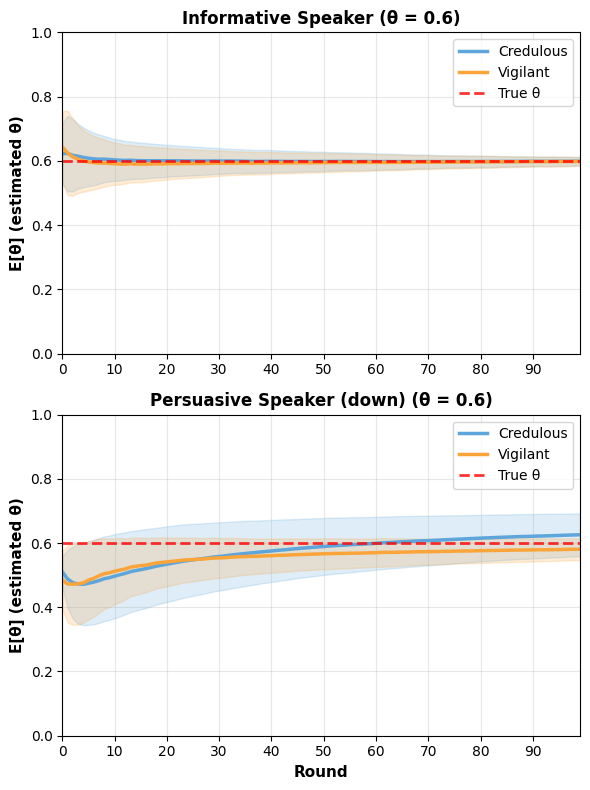

In [49]:
all_statistics = {}
for pairing_name, results_df in all_results.items():
    all_statistics[pairing_name] = compute_bias_and_std(results_df, TRUE_THETA[5])

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
color_cred = '#5DA5DA'  #  - Credulous
color_vig = '#FAA43A'   #  - Vigilant

ax = axes[0]
# S1_inf × L1_cred
stats_inf_cred = all_statistics['S1_inf × L1_cred']
rounds = stats_inf_cred['round'].values
mean_cred = stats_inf_cred['mean_expected'].values
std_cred = stats_inf_cred['std_expected'].values

ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)
# S1_inf × L1_vig
stats_inf_vig = all_statistics['S1_inf × L1_vig']
mean_vig = stats_inf_vig['mean_expected'].values
std_vig = stats_inf_vig['std_expected'].values

ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)
# True theta line
ax.axhline(y=TRUE_THETA[5], color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)
ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'Informative Speaker (θ = {TRUE_THETA[5]})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

ax = axes[1]
# S1_pers_down × L1_cred
stats_pers_cred = all_statistics['S1_pers_down × L1_cred']
mean_cred = stats_pers_cred['mean_expected'].values
std_cred = stats_pers_cred['std_expected'].values
ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)
# S1_pers_down × L1_vig
stats_pers_vig = all_statistics['S1_pers_down × L1_vig']
mean_vig = stats_pers_vig['mean_expected'].values
std_vig = stats_pers_vig['std_expected'].values
ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)
# True theta line
ax.axhline(y=TRUE_THETA[5], color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)
ax.set_xlabel('Round', fontsize=11, fontweight='bold')
ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'Persuasive Speaker (down) (θ = {TRUE_THETA[5]})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

plt.tight_layout()
plt.show()

##### ---#vis: Fig5

In [43]:
"""
N_ROUNDS_SHOW = 20

def extract_map_probabilities(results_df, n_rounds, theta_values):
    n_theta = len(theta_values)
    map_probs = np.zeros((n_rounds, n_theta))
    for round_idx in range(n_rounds):
        round_data = results_df[results_df['round'] == round_idx]
        map_values = round_data['map_theta'].values
        for map_val in map_values:
            theta_idx = np.argmin(np.abs(theta_values - map_val))
            map_probs[round_idx, theta_idx] += 1
        if len(map_values) > 0:
            map_probs[round_idx] /= len(map_values)
    return map_probs

fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(4, 1, hspace=0.4, left=0.12, right=0.92, top=0.96, bottom=0.04)
theta_values = np.array(worldJAX.theta_values)
n_theta = len(theta_values)
true_theta_idx = np.argmin(np.abs(theta_values - TRUE_THETA[5]))

pairings_info = [
    ('S1_inf × L1_cred', 'Informative\n×\nCredulous'),
    ('S1_inf × L1_vig', 'Informative\n×\nVigilant'),
    ('S1_pers_down × L1_cred', 'Persuasive(down)\n×\nCredulous'),
    ('S1_pers_down × L1_vig', 'Persuasive(down)\n×\nVigilant'),
]

for idx, (pairing_name, label) in enumerate(pairings_info):
    results_df = all_results[pairing_name]
    map_probs = extract_map_probabilities(results_df, N_ROUNDS_SHOW, theta_values)
    ax = fig.add_subplot(gs[idx, :])
    im = ax.imshow(map_probs.T, aspect='auto', cmap='Oranges', 
                   origin='lower', interpolation='nearest', vmin=0, vmax=1)
    ax.axhline(y=true_theta_idx, color='blue', linestyle='--', 
               linewidth=2.5, alpha=0.8, label='True θ')
    ax.set_ylabel('MAP θ', fontsize=9, fontweight='bold')
    ax.set_yticks(range(0, n_theta, 2))
    ax.set_yticklabels([f'{theta_values[i]:.1f}' for i in range(0, n_theta, 2)], 
                       fontsize=8)
    if idx < 3:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Round', fontsize=9, fontweight='bold')
        ax.set_xticks(range(0, N_ROUNDS_SHOW, 20))
    ax.set_title(label, fontsize=10, fontweight='bold', pad=8)
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8, framealpha=0.9)

plt.show()
"""


"\nN_ROUNDS_SHOW = 20\n\ndef extract_map_probabilities(results_df, n_rounds, theta_values):\n    n_theta = len(theta_values)\n    map_probs = np.zeros((n_rounds, n_theta))\n    for round_idx in range(n_rounds):\n        round_data = results_df[results_df['round'] == round_idx]\n        map_values = round_data['map_theta'].values\n        for map_val in map_values:\n            theta_idx = np.argmin(np.abs(theta_values - map_val))\n            map_probs[round_idx, theta_idx] += 1\n        if len(map_values) > 0:\n            map_probs[round_idx] /= len(map_values)\n    return map_probs\n\nfig = plt.figure(figsize=(8, 10))\ngs = fig.add_gridspec(4, 1, hspace=0.4, left=0.12, right=0.92, top=0.96, bottom=0.04)\ntheta_values = np.array(worldJAX.theta_values)\nn_theta = len(theta_values)\ntrue_theta_idx = np.argmin(np.abs(theta_values - TRUE_THETA[5]))\n\npairings_info = [\n    ('S1_inf × L1_cred', 'Informative\n×\nCredulous'),\n    ('S1_inf × L1_vig', 'Informative\n×\nVigilant'),\n    ('S1_

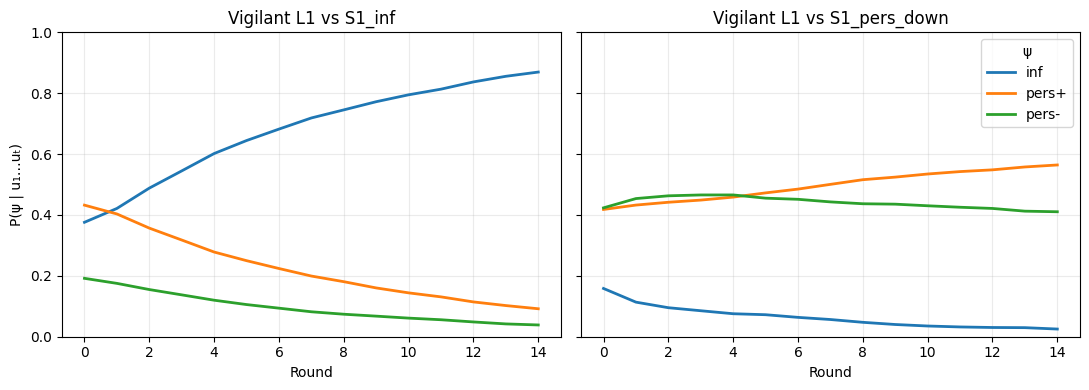

In [50]:
import numpy as np
import matplotlib.pyplot as plt

PSI_LABELS = ["inf", "pers+", "pers-"]  
PAIR_VIG_INF = "S1_inf × L1_vig"
PAIR_VIG_PERSDOWN = "S1_pers_down × L1_vig"

def _psi_mean_by_round(df, max_round=99, psi_col="psi_posteriors"):
    df_plot = df[df["round"] < max_round].dropna(subset=[psi_col]).copy()
    psi_mat = np.stack(df_plot[psi_col].values)  
    df_plot[PSI_LABELS] = psi_mat
    mean_by_round = df_plot.groupby("round")[PSI_LABELS].mean().reset_index()
    s = mean_by_round[PSI_LABELS].sum(axis=1).to_numpy()
    mean_by_round[PSI_LABELS] = mean_by_round[PSI_LABELS].div(s, axis=0)

    return mean_by_round

def plot_vig_psi(all_results, max_round=99):
    if PAIR_VIG_INF not in all_results or PAIR_VIG_PERSDOWN not in all_results:
        raise ValueError(
            f"Need both '{PAIR_VIG_INF}' and '{PAIR_VIG_PERSDOWN}' in all_results keys. "
            f"Got: {list(all_results.keys())}"
        )

    df_inf = all_results[PAIR_VIG_INF]
    df_pers = all_results[PAIR_VIG_PERSDOWN]

    m_inf = _psi_mean_by_round(df_inf, max_round=max_round)
    m_pers = _psi_mean_by_round(df_pers, max_round=max_round)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    for ax, m, title in [
        (axes[0], m_inf, "Vigilant L1 vs S1_inf"),
        (axes[1], m_pers, "Vigilant L1 vs S1_pers_down"),
    ]:
        for psi in PSI_LABELS:
            ax.plot(m["round"], m[psi], label=psi, linewidth=2)
        ax.set_title(title)
        ax.set_xlabel("Round")
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.25)

    axes[0].set_ylabel("P(ψ | u₁…uₜ)")
    axes[1].legend(title="ψ", loc="best")
    plt.tight_layout()
    plt.show()

plot_vig_psi(all_results, max_round=15)


##### ALTERNATIVE: the imagined L0s use fixed distribution

(the image above: the L0 within L1 AND the L0 within S1 both use the default L0 updating rule)

In [44]:
# Alternative simulation function 
def run_single_dyad_simulation_X(
    true_theta: float,
    speaker_psi: float,  # 0.0=inf, 2.0=pers_down
    listener_type: str,  # 'cred' or 'vig'
    world: WorldJAX,
    n_rounds: int,
    run_seed: int,
    alpha: float = 3.0,
    alpha_dist = None,
    alpha_values = None,
    psi_dist = None
) -> Dict:
    # Initialize
    theta_values = world.theta_values
    uniform_prior = jnp.ones(len(theta_values)) / len(theta_values)
    
    # Storage
    expected_thetas = []
    map_thetas = []
    posteriors = []
    observations_list = []  
    utterances_list = [] 
    psi_posteriors = []
    alpha_posteriors = []
    # Current listener belief (updated each round)
    listener_prior = uniform_prior
    listener_psi_belief = psi_dist.copy() if psi_dist is not None else None
    listener_alpha_belief = alpha_dist.copy() if alpha_dist is not None else None

    # Sample observations for this run
    observations_df = world.sample_run(theta=true_theta, n_round=n_rounds, run_seed=run_seed)
    observations = observations_df['observation'].values
    
    for round_idx in range(n_rounds):
        # 1. World generates observation
        obs = observations[round_idx]
        obs_idx = world.observations.index(obs)
        observations_list.append(obs)
        # 2. Speaker produces utterance
        speaker_dist = S1_pers(uniform_prior, alpha, theta_values, speaker_psi)[obs_idx, :]
        
        # 3. Sample utterance from speaker distribution
        rng = np.random.default_rng(run_seed + round_idx * 10000)
        u_idx = rng.choice(len(speaker_dist), p=np.array(speaker_dist))
        utterances_list.append(world.utterances[u_idx])
        # 4. Listener updates belief based on utterance
        if listener_type == 'cred':
            listener_full_dist = L1_cred(listener_prior, uniform_prior, listener_alpha_belief, alpha_values)[u_idx, :, :]
            posterior = jnp.sum(listener_full_dist, axis=1)  # Marginalize over alpha
            alpha_posterior = jnp.sum(listener_full_dist, axis=0)  # sum over theta
            alpha_posterior = alpha_posterior / jnp.sum(alpha_posterior)
            alpha_posteriors.append(alpha_posterior)
            psi_posteriors.append(None)
            listener_alpha_belief = alpha_posterior
        elif listener_type == 'vig':
            listener_full_dist = L1_vig(listener_prior, uniform_prior, listener_alpha_belief, alpha_values, listener_psi_belief, theta_values)[u_idx, :, :, :]
            posterior = jnp.sum(listener_full_dist, axis=(1, 2))  
            psi_posterior = jnp.sum(listener_full_dist, axis=(0, 1))
            alpha_posterior = jnp.sum(listener_full_dist, axis=(0, 2))  
            psi_posterior = psi_posterior / jnp.sum(psi_posterior)
            alpha_posterior = alpha_posterior / jnp.sum(alpha_posterior)
            psi_posteriors.append(psi_posterior)
            alpha_posteriors.append(alpha_posterior)
            listener_psi_belief = psi_posterior
            listener_alpha_belief = alpha_posterior
        else:
            raise ValueError(f"Unknown listener type: {listener_type}")
        
        posterior = posterior / jnp.sum(posterior)
        
        # 5. Compute statistics
        expected_theta = compute_expected_theta(posterior, theta_values)
        map_theta = compute_map_theta(posterior, theta_values)
        
        # 6. Store results
        expected_thetas.append(float(expected_theta))
        map_thetas.append(float(map_theta))
        posteriors.append(posterior)
        
        # 7. Update prior for next round (Bayesian learning)
        listener_prior = posterior
    
    return {
        'expected_theta': expected_thetas,
        'map_theta': map_thetas,
        'posteriors': posteriors,
        'psi_posteriors': psi_posteriors,
        'alpha_posteriors': alpha_posteriors,
        'observations': observations_list,  
        'utterances': utterances_list
    }
    
def run_dyad_simulations_X(
    pairing_name: str,
    true_theta: float,
    speaker_psi: float,
    listener_type: str,
    world: WorldJAX,
    n_runs: int = 1000,
    n_rounds: int = 100,
    base_seed: int = 42,
    alpha: float = 3.0,
    alpha_dist = None,
    alpha_values = None,
    psi_dist = None
) -> pd.DataFrame:
    print(f"\n{'='*60}")
    print(f"Running: {pairing_name}")
    print(f"True θ = {true_theta:.2f} | Runs = {n_runs} | Rounds = {n_rounds}")
    print(f"{'='*60}")
    
    start_time = time.time()
    all_results = []
    
    for run_id in tqdm(range(n_runs), desc=f'Running {pairing_name} runs...'):
        run_seed = base_seed + run_id
        
        # Run single simulation
        run_results = run_single_dyad_simulation_X(
            true_theta=true_theta,
            speaker_psi=speaker_psi,
            listener_type=listener_type,
            world=world,
            n_rounds=n_rounds,
            run_seed=run_seed,
            alpha=alpha,
            alpha_dist=alpha_dist,
            alpha_values=alpha_values,
            psi_dist=psi_dist
        )
        
        # Store results for each round
        for round_idx in range(n_rounds):
            all_results.append({
                'pairing': pairing_name,
                'run_id': run_id,
                'round': round_idx,
                'expected_theta': run_results['expected_theta'][round_idx],
                'map_theta': run_results['map_theta'][round_idx],
                'posteriors': run_results['posteriors'][round_idx],
                'psi_posteriors': run_results['psi_posteriors'][round_idx],
                'alpha_posteriors': run_results['alpha_posteriors'][round_idx],
                'observation': run_results['observations'][round_idx],
                'utterance': run_results['utterances'][round_idx]       
            })
    
    
    elapsed_time = time.time() - start_time
    
    print(f"✓ Completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"  Average time per run: {elapsed_time/n_runs:.4f} seconds")
    
    return pd.DataFrame(all_results)

print("✓ Simulation functions loaded successfully!")

✓ Simulation functions loaded successfully!


In [45]:
all_results = {}
pairings = [
    {'name': 'S1_inf × L1_cred', 'speaker_psi': 0.0, 'listener': 'cred'},
    {'name': 'S1_inf × L1_vig', 'speaker_psi': 0.0, 'listener': 'vig'},
    {'name': 'S1_pers_down × L1_cred', 'speaker_psi': 2.0, 'listener': 'cred'},
    {'name': 'S1_pers_down × L1_vig', 'speaker_psi': 2.0, 'listener': 'vig'},
]
TRUE_THETA = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for pairing in pairings:
    results_df = run_dyad_simulations_X(
        pairing_name=pairing['name'],
        true_theta=TRUE_THETA[5],
        speaker_psi=pairing['speaker_psi'],
        listener_type=pairing['listener'],
        world=worldJAX,
        n_runs=N_RUNS,
        n_rounds=N_ROUNDS,
        base_seed=BASE_SEED,
        alpha=ALPHA_VAL,
        alpha_dist=alpha_dist,
        alpha_values=alpha_values_memo,
        psi_dist=Psi_dist
    )
    all_results[pairing['name']] = results_df



Running: S1_inf × L1_cred
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_inf × L1_cred runs...: 100%|██████████| 1000/1000 [00:44<00:00, 22.66it/s]


✓ Completed in 44.14 seconds (0.74 minutes)
  Average time per run: 0.0441 seconds

Running: S1_inf × L1_vig
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_inf × L1_vig runs...: 100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


✓ Completed in 49.09 seconds (0.82 minutes)
  Average time per run: 0.0491 seconds

Running: S1_pers_down × L1_cred
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_pers_down × L1_cred runs...: 100%|██████████| 1000/1000 [00:45<00:00, 22.21it/s]


✓ Completed in 45.03 seconds (0.75 minutes)
  Average time per run: 0.0450 seconds

Running: S1_pers_down × L1_vig
True θ = 0.60 | Runs = 1000 | Rounds = 100


Running S1_pers_down × L1_vig runs...: 100%|██████████| 1000/1000 [00:51<00:00, 19.24it/s]


✓ Completed in 51.99 seconds (0.87 minutes)
  Average time per run: 0.0520 seconds


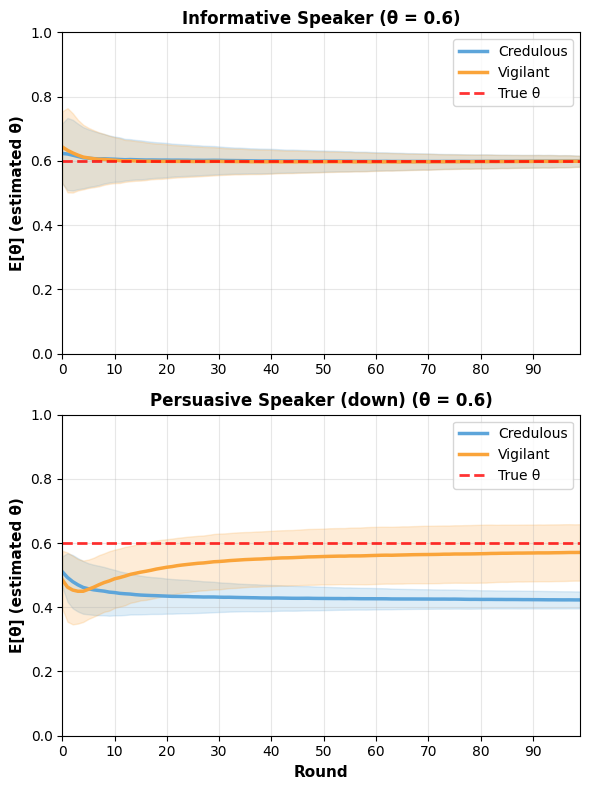

In [46]:
all_statistics = {}
for pairing_name, results_df in all_results.items():
    all_statistics[pairing_name] = compute_bias_and_std(results_df, TRUE_THETA[5])

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
color_cred = '#5DA5DA'  #  - Credulous
color_vig = '#FAA43A'   #  - Vigilant

ax = axes[0]
# S1_inf × L1_cred
stats_inf_cred = all_statistics['S1_inf × L1_cred']
rounds = stats_inf_cred['round'].values
mean_cred = stats_inf_cred['mean_expected'].values
std_cred = stats_inf_cred['std_expected'].values

ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)
# S1_inf × L1_vig
stats_inf_vig = all_statistics['S1_inf × L1_vig']
mean_vig = stats_inf_vig['mean_expected'].values
std_vig = stats_inf_vig['std_expected'].values

ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)
# True theta line
ax.axhline(y=TRUE_THETA[5], color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)
ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'Informative Speaker (θ = {TRUE_THETA[5]})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

ax = axes[1]
# S1_pers_down × L1_cred
stats_pers_cred = all_statistics['S1_pers_down × L1_cred']
mean_cred = stats_pers_cred['mean_expected'].values
std_cred = stats_pers_cred['std_expected'].values
ax.plot(rounds, mean_cred, color=color_cred, linewidth=2.5, label='Credulous', linestyle='-')
ax.fill_between(rounds, mean_cred - std_cred, mean_cred + std_cred, 
                 color=color_cred, alpha=0.2)
# S1_pers_down × L1_vig
stats_pers_vig = all_statistics['S1_pers_down × L1_vig']
mean_vig = stats_pers_vig['mean_expected'].values
std_vig = stats_pers_vig['std_expected'].values
ax.plot(rounds, mean_vig, color=color_vig, linewidth=2.5, label='Vigilant', linestyle='-')
ax.fill_between(rounds, mean_vig - std_vig, mean_vig + std_vig, 
                 color=color_vig, alpha=0.2)
# True theta line
ax.axhline(y=TRUE_THETA[5], color='red', linestyle='--', linewidth=2, label=f'True θ', alpha=0.8)
ax.set_xlabel('Round', fontsize=11, fontweight='bold')
ax.set_ylabel('E[θ] (estimated θ)', fontsize=11, fontweight='bold')
ax.set_title(f'Persuasive Speaker (down) (θ = {TRUE_THETA[5]})', fontsize=12, fontweight='bold')
ax.set_xlim([0, N_ROUNDS-1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
ax.set_xticks(range(0, N_ROUNDS, 10))

plt.tight_layout()
plt.show()

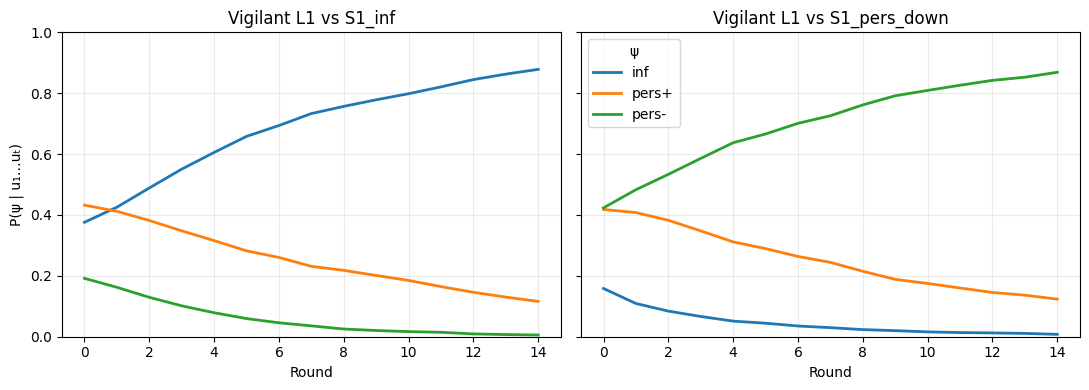

In [47]:
import numpy as np
import matplotlib.pyplot as plt

PSI_LABELS = ["inf", "pers+", "pers-"]  
PAIR_VIG_INF = "S1_inf × L1_vig"
PAIR_VIG_PERSDOWN = "S1_pers_down × L1_vig"

def _psi_mean_by_round(df, max_round=99, psi_col="psi_posteriors"):
    df_plot = df[df["round"] < max_round].dropna(subset=[psi_col]).copy()
    psi_mat = np.stack(df_plot[psi_col].values)  
    df_plot[PSI_LABELS] = psi_mat
    mean_by_round = df_plot.groupby("round")[PSI_LABELS].mean().reset_index()
    s = mean_by_round[PSI_LABELS].sum(axis=1).to_numpy()
    mean_by_round[PSI_LABELS] = mean_by_round[PSI_LABELS].div(s, axis=0)

    return mean_by_round

def plot_vig_psi(all_results, max_round=99):
    if PAIR_VIG_INF not in all_results or PAIR_VIG_PERSDOWN not in all_results:
        raise ValueError(
            f"Need both '{PAIR_VIG_INF}' and '{PAIR_VIG_PERSDOWN}' in all_results keys. "
            f"Got: {list(all_results.keys())}"
        )

    df_inf = all_results[PAIR_VIG_INF]
    df_pers = all_results[PAIR_VIG_PERSDOWN]

    m_inf = _psi_mean_by_round(df_inf, max_round=max_round)
    m_pers = _psi_mean_by_round(df_pers, max_round=max_round)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    for ax, m, title in [
        (axes[0], m_inf, "Vigilant L1 vs S1_inf"),
        (axes[1], m_pers, "Vigilant L1 vs S1_pers_down"),
    ]:
        for psi in PSI_LABELS:
            ax.plot(m["round"], m[psi], label=psi, linewidth=2)
        ax.set_title(title)
        ax.set_xlabel("Round")
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.25)

    axes[0].set_ylabel("P(ψ | u₁…uₜ)")
    axes[1].legend(title="ψ", loc="best")
    plt.tight_layout()
    plt.show()

plot_vig_psi(all_results, max_round=15)


##### DEBUG: Why does L1_vig infer pers+ when speaker is S1_pers_down?|

In [20]:
print("="*80)
print("DIAGNOSTIC: Checking psi inference for S1_pers_down speaker")
print("="*80)

# Setup
alpha_val = 3.0
alpha_dist = jnp.array([1.0])
alpha_values_memo = jnp.array([alpha_val])
Psi_dist = jnp.array([1/3, 1/3, 1/3])
uniform_prior = jnp.ones(len(worldJAX.theta_values)) / len(worldJAX.theta_values)

# Choose a low-theta observation (where pers_down should be different from pers_up)
obs_idx = 5  # 2/7 effective
print(f"\nObservation: {worldJAX.observations[obs_idx]} (2/7 effective)")
print(f"This is a LOW effectiveness scenario\n")

# Generate speaker distributions
S1_inf_dist = S1_pers(uniform_prior, alpha_val, worldJAX.theta_values, 0.0)[obs_idx, :]
S1_pers_up_dist = S1_pers(uniform_prior, alpha_val, worldJAX.theta_values, 1.0)[obs_idx, :]
S1_pers_down_dist = S1_pers(uniform_prior, alpha_val, worldJAX.theta_values, 2.0)[obs_idx, :]

print("Speaker utterance probabilities P(u|obs):")
print(f"{'Utterance':<20} {'S1_inf':>10} {'S1_pers↑':>10} {'S1_pers↓':>10}")
print("-"*55)
for u_idx, utt in enumerate(worldJAX.utterances):
    print(f"{utt:<20} {S1_inf_dist[u_idx]:>10.4f} {S1_pers_up_dist[u_idx]:>10.4f} {S1_pers_down_dist[u_idx]:>10.4f}")

# Find most distinctive utterances
most_likely_pers_down = jnp.argmax(S1_pers_down_dist)
most_likely_pers_up = jnp.argmax(S1_pers_up_dist)

print(f"\nMost likely from S1_pers_down: '{worldJAX.utterances[most_likely_pers_down]}'")
print(f"Most likely from S1_pers_up:   '{worldJAX.utterances[most_likely_pers_up]}'")

# Now check L1_vig's inference
L1_vig_full = L1_vig(uniform_prior, alpha_dist, alpha_values_memo, Psi_dist, worldJAX.theta_values)

print("\n" + "="*80)
print("L1_VIG's INFERENCE: P(psi|u) for key utterances")
print("="*80)

for test_u_idx, label in [(most_likely_pers_down, "Most likely from pers_down"),
                           (most_likely_pers_up, "Most likely from pers_up")]:
    psi_posterior = jnp.sum(L1_vig_full[test_u_idx, :, :, :], axis=(0, 1))
    psi_posterior = psi_posterior / jnp.sum(psi_posterior)
    
    print(f"\nUtterance: '{worldJAX.utterances[test_u_idx]}' ({label})")
    print(f"  P(psi=inf | u)       = {psi_posterior[0]:.4f}")
    print(f"  P(psi=pers_up | u)   = {psi_posterior[1]:.4f}")
    print(f"  P(psi=pers_down | u) = {psi_posterior[2]:.4f}")
    print(f"  Speaker likelihoods: inf={S1_inf_dist[test_u_idx]:.4f}, pers_up={S1_pers_up_dist[test_u_idx]:.4f}, pers_down={S1_pers_down_dist[test_u_idx]:.4f}")
    
    if label == "Most likely from pers_down":
        if psi_posterior[1] > psi_posterior[2]:
            print("  ⚠️  BUG: L1_vig thinks pers_up is MORE likely than pers_down!")
        else:
            print("  ✓ Correct: L1_vig correctly identifies pers_down")

# Check what L0_expected_theta returns for different utterances
print("\n" + "="*80)
print("DEEPER CHECK: What does L0_expected_theta return?")
print("="*80)
print(f"{'Utterance':<20} {'E[θ|u] from L0':>20}")
print("-"*45)

DIAGNOSTIC: Checking psi inference for S1_pers_down speaker

Observation: (0, 0, 0, 0, 0, 0, 5, 0) (2/7 effective)
This is a LOW effectiveness scenario

Speaker utterance probabilities P(u|obs):
Utterance                S1_inf   S1_pers↑   S1_pers↓
-------------------------------------------------------
all,all,successful       0.0000     0.0000     0.0000
all,all,unsuccessful     0.0000     0.0000     0.0000
all,most,successful      0.3336     0.1809     0.0022
all,most,unsuccessful     0.0000     0.0000     0.0000
all,some,successful      0.0276     0.0780     0.0302
all,some,unsuccessful     0.0276     0.0134     0.1755
all,no,successful        0.0000     0.0000     0.0000
all,no,unsuccessful      0.0000     0.0000     0.0000
most,all,successful      0.0000     0.0000     0.0000
most,all,unsuccessful     0.0000     0.0000     0.0000
most,most,successful     0.0807     0.1274     0.0095
most,most,unsuccessful     0.0000     0.0000     0.0000
most,some,successful     0.0150     0.0530

In [21]:
# DIAGNOSTIC: Check what happens in actual simulation rounds
print("\n" + "="*80)
print("SIMULATION DIAGNOSTIC: First 25 rounds of S1_pers_down × L1_vig")
print("="*80)

# Get the results from your simulation
df_pers_vig = all_results['S1_pers_down × L1_vig']

# Look at first run, first 10 rounds
run_0_data = df_pers_vig[df_pers_vig['run_id'] == 0].head(25)

print(f"\n{'Round':<8} {'Observation':<25} {'Utterance':<25} {'P(inf)':<10} {'P(pers+)':<10} {'P(pers-)':<10}")
print("-"*100)

for _, row in run_0_data.iterrows():
    psi_post = row['psi_posteriors']
    print(f"{row['round']:<8} {str(row['observation']):<25} {row['utterance']:<25} {psi_post[0]:.4f}     {psi_post[1]:.4f}      {psi_post[2]:.4f}")

# Check which utterances are being produced
print("\n" + "="*80)
print("UTTERANCE FREQUENCY in S1_pers_down × L1_vig (first 100 rounds, run 0)")
print("="*80)

run_0_full = df_pers_vig[df_pers_vig['run_id'] == 0].head(100)
utterance_counts = run_0_full['utterance'].value_counts()
print(utterance_counts)

# Compare with what S1_inf would produce
print("\n" + "="*80)  
print("UTTERANCE FREQUENCY in S1_inf × L1_vig (first 100 rounds, run 0)")
print("="*80)

df_inf_vig = all_results['S1_inf × L1_vig']
run_0_inf = df_inf_vig[df_inf_vig['run_id'] == 0].head(100)
utterance_counts_inf = run_0_inf['utterance'].value_counts()
print(utterance_counts_inf)


SIMULATION DIAGNOSTIC: First 25 rounds of S1_pers_down × L1_vig

Round    Observation               Utterance                 P(inf)     P(pers+)   P(pers-)  
----------------------------------------------------------------------------------------------------
0        (0, 0, 1, 1, 2, 0, 1, 0)  no,all,successful         0.2128     0.2548      0.5324
1        (0, 0, 1, 0, 0, 2, 1, 1)  most,some,successful      0.0936     0.3750      0.5313
2        (0, 0, 1, 1, 0, 2, 0, 1)  most,some,successful      0.0296     0.4220      0.5484
3        (0, 0, 0, 0, 2, 2, 1, 0)  most,some,successful      0.0088     0.4449      0.5462
4        (0, 0, 1, 0, 1, 2, 1, 0)  most,some,unsuccessful    0.0025     0.4409      0.5566
5        (0, 1, 1, 1, 1, 1, 0, 0)  no,all,unsuccessful       0.0015     0.5305      0.4681
6        (0, 0, 0, 1, 4, 0, 0, 0)  no,all,successful         0.0009     0.4561      0.5430
7        (0, 0, 0, 0, 2, 3, 0, 0)  all,some,unsuccessful     0.0005     0.4127      0.5868
8        (0